In [82]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
import exocartographer.gp_emission_map as gem
import exocartographer.util as u
import healpy
import IPython.display as disp
import matplotlib.animation as anim
from matplotlib.colors import LogNorm
import scipy.optimize as so
import scipy.signal as ss

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<Container object of 3 artists>

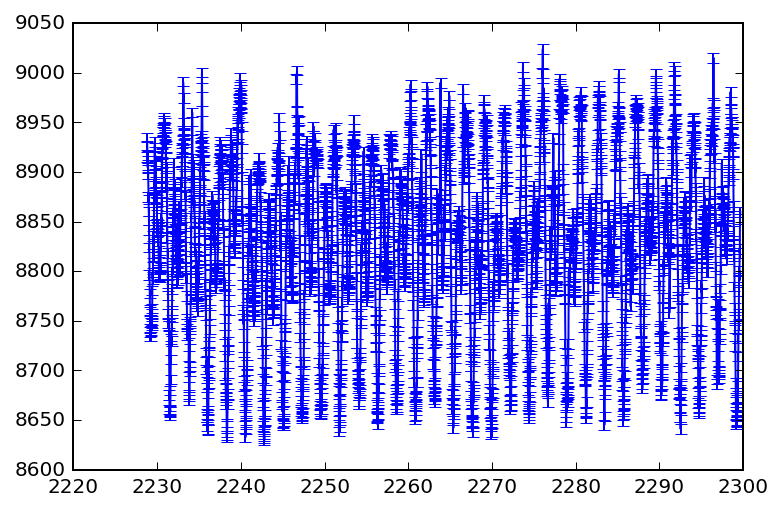

In [7]:
lc1 = loadtxt('epic211098454.txt')
errorbar(lc1[:,0], lc1[:,1], lc1[:,2])

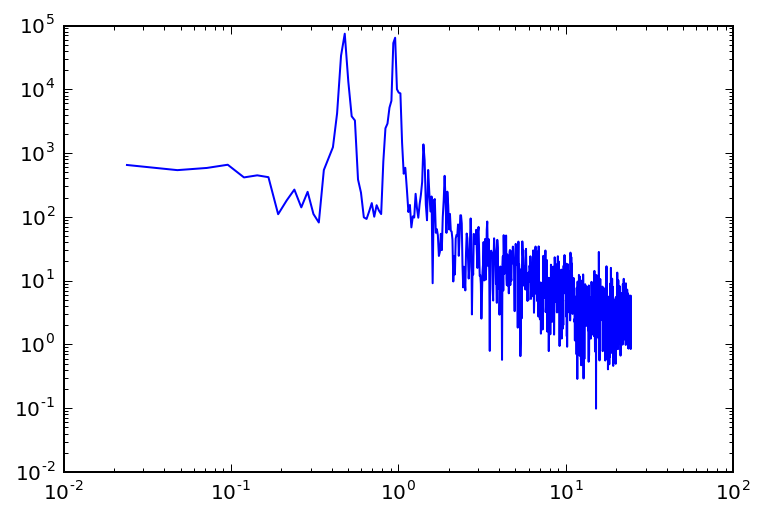

In [88]:
fs, psd = ss.welch(lc1[:,1], fs=1.0/diff(lc1[:,0])[0], nperseg=2048)
loglog(fs, psd)

In [175]:
P0 = 1.129 # From README

In [189]:
reload(gem)

<module 'exocartographer.gp_emission_map' from '/Users/farr/Documents/code/exocartographer/exocartographer/gp_emission_map.py'>

In [190]:
mappost = gem.EmissionMapPosterior(lc1[:,0], log(lc1[:,1]), lc1[:,1]/lc1[:,2])

In [191]:
gppbest = so.fmin_powell(lambda x: -mappost.gp_marginalised_posterior(x), zeros(6))

ValueError: operands could not be broadcast together with shapes (192,192) (3204,3204) 

In [177]:
p0 = mappost.to_params(zeros(mappost.nparams))
p0['logit_wn_rel_amp'] = u.logit(0.1, mappost.wn_low, mappost.wn_high)
p0['logit_spatial_scale'] = u.logit(pi/4.0, mappost.spatial_scale_low, mappost.spatial_scale_high)
p0['log_period'] = log(P0)
p0['logit_cos_theta'] = u.logit(0.5)
p0['log_intensity_map'] = randn(mappost.npix) # initial guess
p0['log_sigma'] = log(std(log(lc1[:,1]))/std(mappost.intensity_series(p0)))
p0['log_intensity_map'] = exp(p0['log_sigma'])*randn(mappost.npix)
p0['mu'] = mean(p0['log_intensity_map']) + mean(log(lc1[:,1])) - mean(mappost.intensity_series(p0))
p0['log_intensity_map'] += p0['mu']

In [178]:
def all_but_period_posterior(x):
    xx = insert(x, 4, P0)
    return mappost(xx)

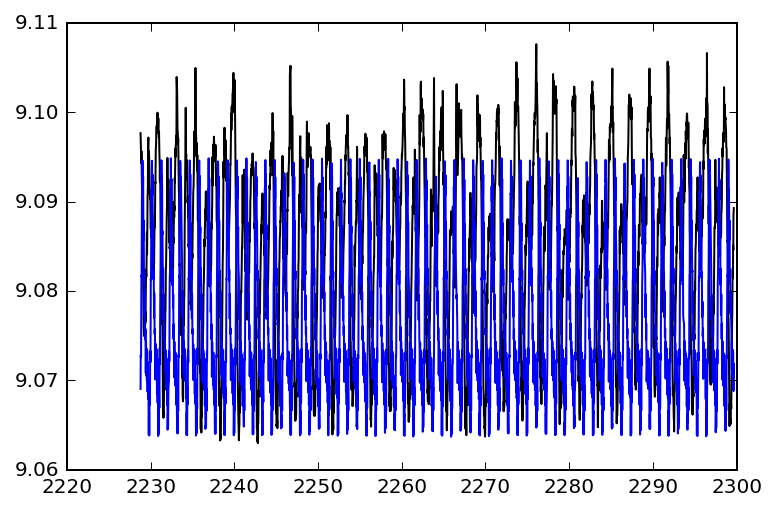

In [179]:
plot(lc1[:,0], log(lc1[:,1]), '-k')
plot(lc1[:,0], mappost.intensity_series(p0))

In [180]:
pp = p0.reshape((1,)).view(float)
cb_best = concatenate((pp[:4], pp[5:]))
def cb(x):
    global cb_best
    cb_best = x
    p = mappost.to_params(insert(x, 4, P0))
    m = exp(p['log_intensity_map'])
    disp.clear_output(wait=True)
    figure(1)
    clf()
    healpy.mollview(m, cmap='viridis', fig=1, norm=LogNorm())
    disp.display(gcf())
    figure(2)
    clf()
    plot(lc1[:,0], log(lc1[:,1]), '-k')
    plot(lc1[:,0], mappost.intensity_series(p), '-b')
    disp.display(gcf())

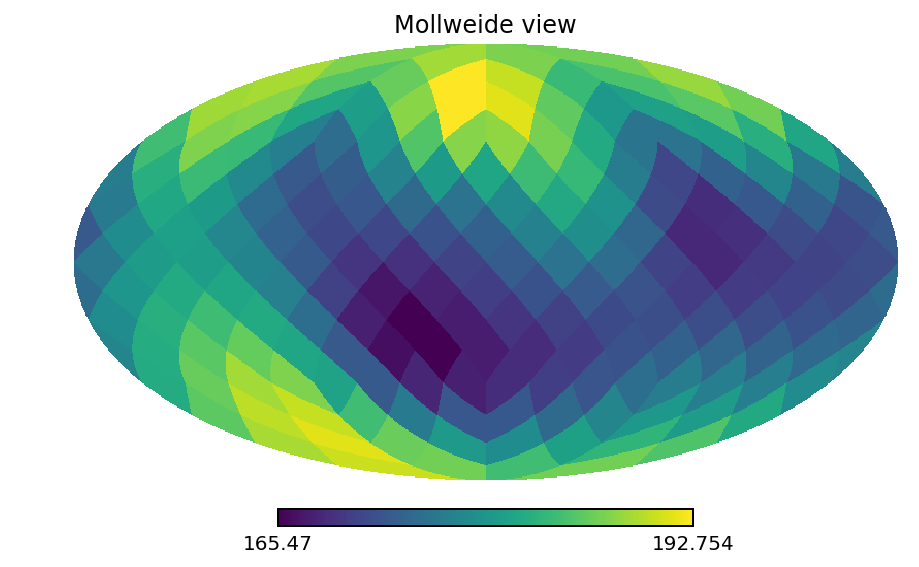

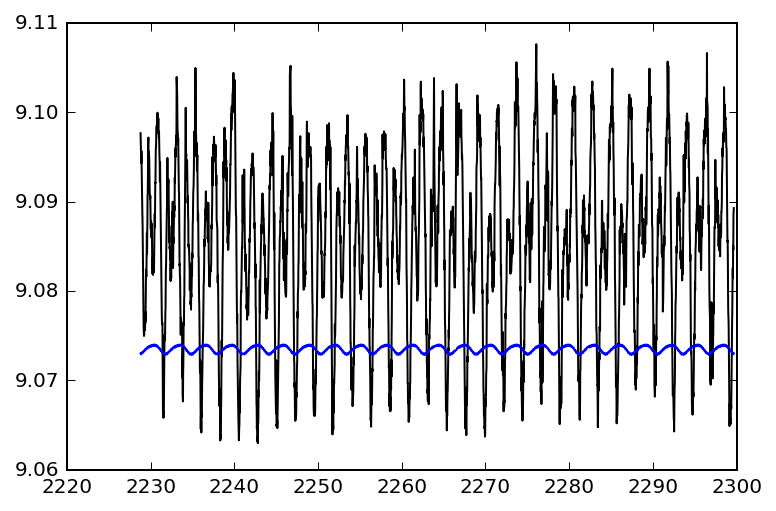

KeyboardInterrupt: 

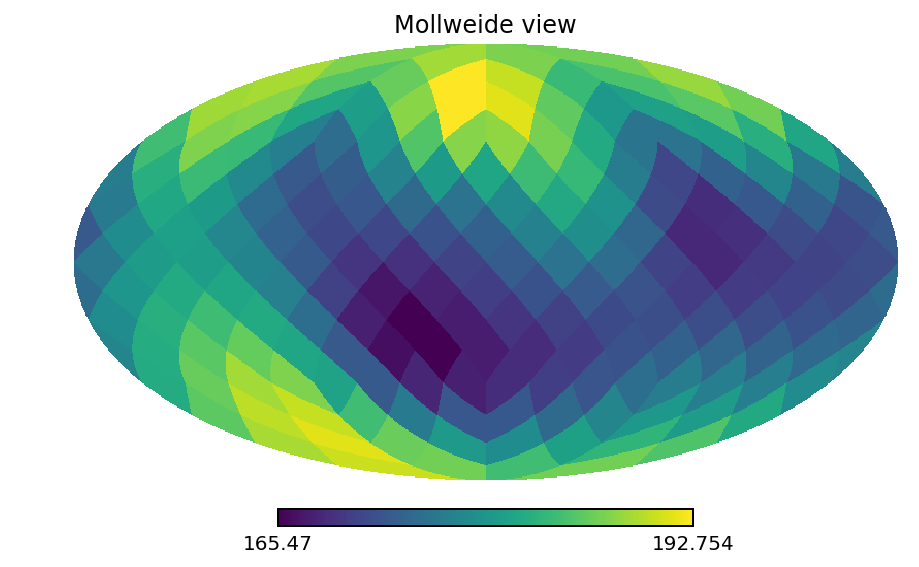

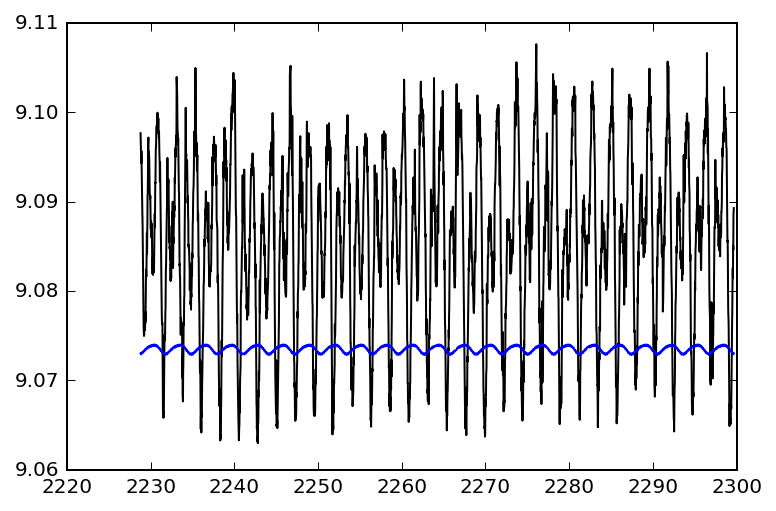

In [182]:
pbest = so.fmin_powell(lambda x: -all_but_period_posterior(x), cb_best, callback=cb)

In [183]:
reload(gem)

<module 'exocartographer.gp_emission_map' from '/Users/farr/Documents/code/exocartographer/exocartographer/gp_emission_map.py'>